# DBSCAN: Density-Based Spatial Clustering of Applications with Noise

DBSCAN is an unsupervised machine learning algorithm used for clustering tasks. It is particularly effective for identifying clusters of arbitrary shape and handling noise (outliers).

## Key Concepts
- **Core Points**: Points with at least a minimum number of neighbors (`minPts`) within a specified radius (`eps`).
- **Border Points**: Points within the `eps` radius of a core point but with fewer than `minPts` neighbors.
- **Noise Points**: Points that are neither core points nor border points.

## Parameters
1. **`eps`**: The radius of the neighborhood around a point.
2. **`minPts`**: The minimum number of points required to form a dense region (a cluster).

## Algorithm Steps
1. Start with an unvisited point.
2. If the point is a core point (has at least `minPts` points within `eps`):
   - Create a new cluster.
   - Add all directly connected points (within `eps`) to this cluster.
   - Recursively expand the cluster by visiting neighbors of neighbors.
3. If the point is not a core point and not connected to any cluster, label it as noise.
4. Repeat until all points are visited.

## Advantages
- **No need to specify the number of clusters**: The algorithm determines clusters based on data distribution.
- **Handles arbitrary shapes**: Unlike k-means, DBSCAN identifies clusters of any shape.
- **Noise resilience**: Explicitly labels noise points for outlier detection.

## Limitations
- **Parameter sensitivity**: Proper selection of `eps` and `minPts` is crucial for good results.
- **Scalability**: DBSCAN can be computationally intensive for large datasets.
- **Difficulty with varying densities**: Struggles with clusters that have widely varying densities.

## Applications
- Anomaly detection (e.g., fraud detection, fault detection).
- Spatial data analysis (e.g., geographic clustering).
- Customer segmentation.
- Community detection in social networks.


## Load Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

## Generate dataset and scale the features

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate the dataset (2D and 3D options)
X, _ = make_moons(n_samples=200, noise=0.05, random_state=42)
# Uncomment the following line to use a 3D dataset:
# X, _ = make_swiss_roll(n_samples=500, noise=0.05, random_state=42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Create DBSCAN Functions and Evaluate Parameters

In [ ]:
# Function to evaluate DBSCAN for different parameters
def evaluate_dbscan(X, eps_range, min_samples_range):
    results = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Compute metrics only if there are valid clusters
            if n_clusters > 0 and len(unique_labels - {-1}) > 1:
                silhouette = silhouette_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            else:
                silhouette = -1
                ch_score = -1

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': ch_score
            })
    return results

# Dynamic parameter range adjustment
def dynamic_range(param, step, multiplier=1.5, iterations=2):
    ranges = [param]
    for _ in range(iterations - 1):
        param = np.arange(param[0], param[-1] * multiplier, step * multiplier)
        ranges.append(param)
    return np.unique(np.concatenate(ranges))

# Initial parameter ranges
eps_range = dynamic_range(np.arange(0.1, 0.5, 0.05), step=0.05)
min_samples_range = range(3, 10)

# Evaluate parameters
results = evaluate_dbscan(X_scaled, eps_range, min_samples_range)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find best parameters based on silhouette score
best_params = results_df.loc[results_df['silhouette_score'].idxmax()]


## Visualizations

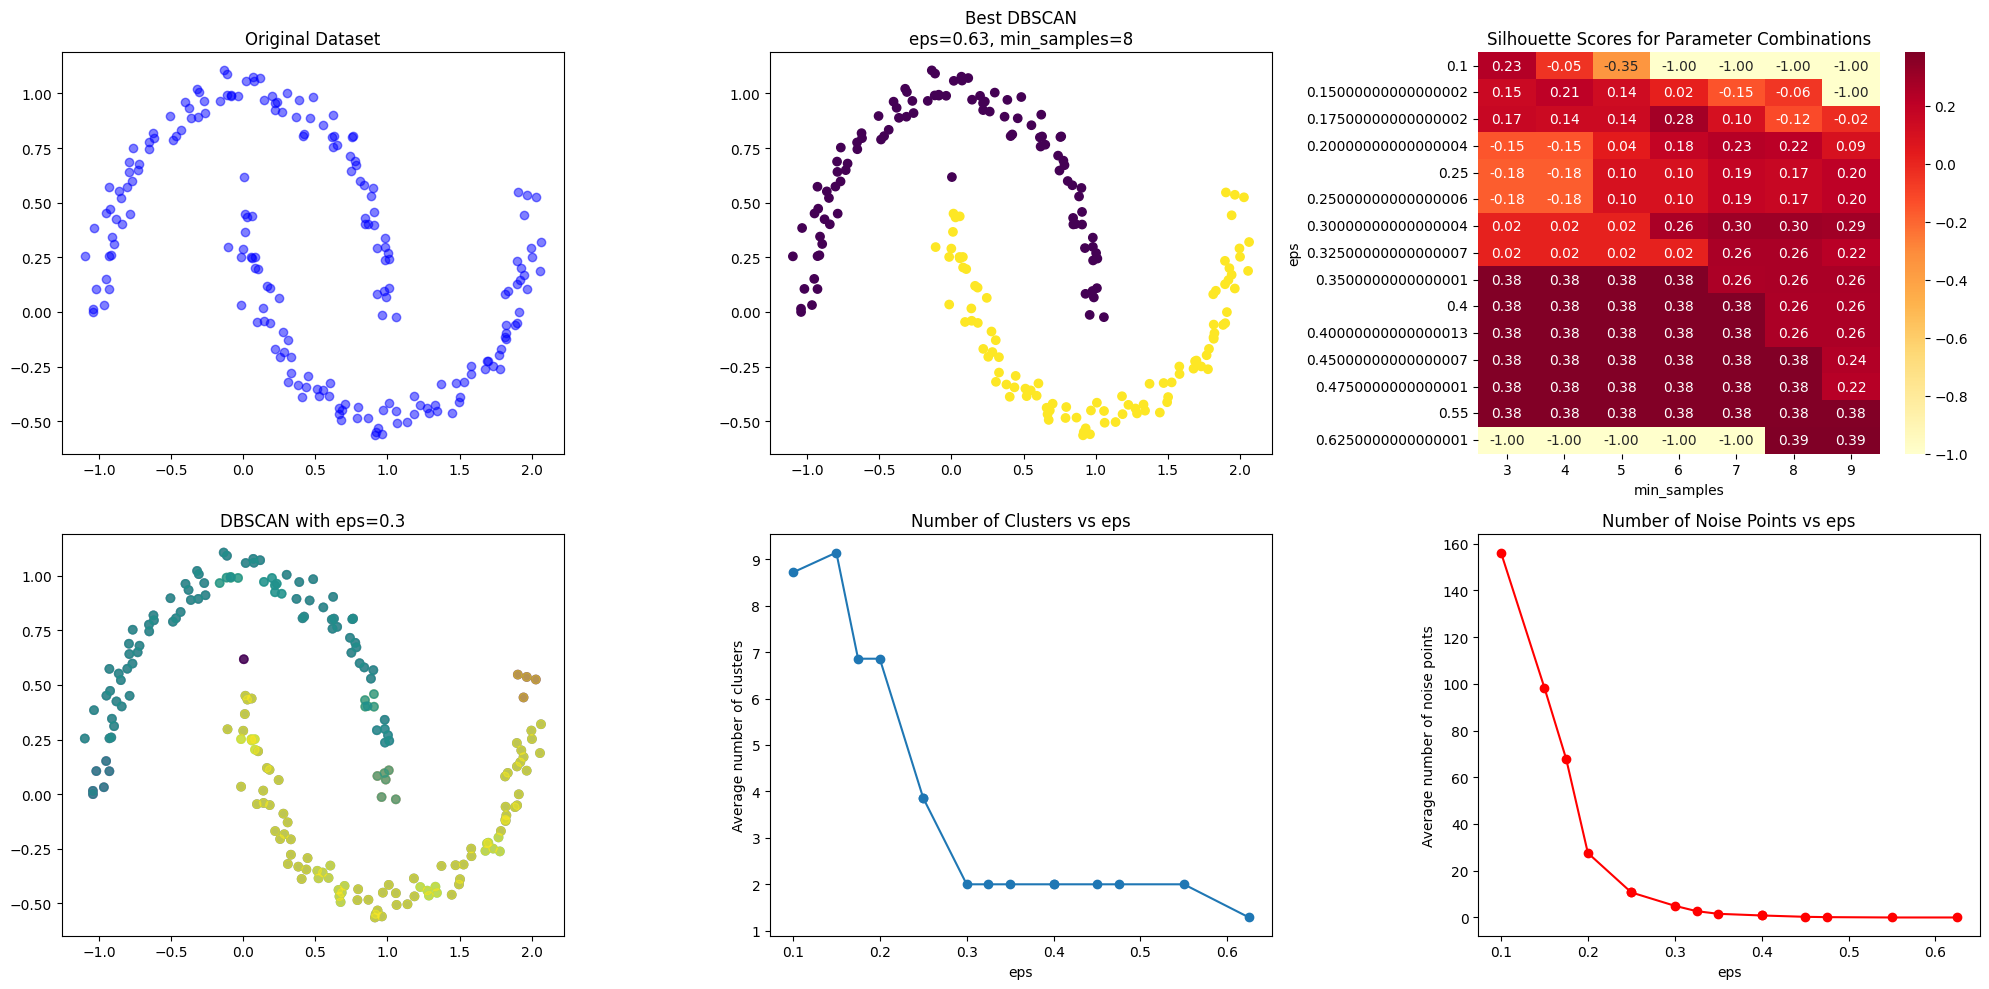


Best Parameters:
eps: 0.625
min_samples: 8
Number of clusters: 2.0
Number of noise points: 0.0
Silhouette score: 0.386
Calinski-Harabasz score: 173.401


In [1]:
fig = plt.figure(figsize=(20, 10))

# 1. Original Data
ax = fig.add_subplot(231, projection='3d' if X.shape[1] == 3 else None)
if X.shape[1] == 3:
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', alpha=0.5)
else:
    ax.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)
ax.set_title('Original Dataset')

# 2. Best DBSCAN Result
best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
labels_best = best_dbscan.fit_predict(X_scaled)

ax = fig.add_subplot(232, projection='3d' if X.shape[1] == 3 else None)
if X.shape[1] == 3:
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels_best, cmap='viridis')
else:
    ax.scatter(X[:, 0], X[:, 1], c=labels_best, cmap='viridis')
ax.set_title(f'Best DBSCAN\neps={best_params["eps"]:.2f}, min_samples={int(best_params["min_samples"])}')

# 3. Silhouette Scores Heatmap
plt.subplot(233)
pivot_table = results_df.pivot(index='eps', columns='min_samples', values='silhouette_score')
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Silhouette Scores for Parameter Combinations')

# 4. Different eps values demonstration
plt.subplot(234)
eps_values = [0.1, 0.2, 0.3]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(f'DBSCAN with eps={eps}')

# 5. Number of clusters vs eps
plt.subplot(235)
eps_clusters = results_df.groupby('eps')['n_clusters'].mean()
plt.plot(eps_clusters.index, eps_clusters.values, marker='o')
plt.xlabel('eps')
plt.ylabel('Average number of clusters')
plt.title('Number of Clusters vs eps')

# 6. Number of noise points vs eps
plt.subplot(236)
eps_noise = results_df.groupby('eps')['n_noise'].mean()
plt.plot(eps_noise.index, eps_noise.values, marker='o', color='red')
plt.xlabel('eps')
plt.ylabel('Average number of noise points')
plt.title('Number of Noise Points vs eps')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBest Parameters:")
print(f"eps: {best_params['eps']:.3f}")
print(f"min_samples: {int(best_params['min_samples'])}")
print(f"Number of clusters: {best_params['n_clusters']}")
print(f"Number of noise points: {best_params['n_noise']}")
print(f"Silhouette score: {best_params['silhouette_score']:.3f}")
print(f"Calinski-Harabasz score: {best_params['calinski_harabasz_score']:.3f}")


## Observations

- The DBSCAN algorithm successfully identified two clusters in the dataset, aligning with the structure of the `make_moons` dataset.
- A silhouette score of 0.386 is decent but could indicate some overlap between clusters or suboptimal compactness.
- The Calinski-Harabasz score confirms that the clustering is relatively well-defined.
